<a href="https://colab.research.google.com/github/EricEricEricJin/ECE539-Group-Project/blob/master/slicer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras

import os
import re

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
CHUNK_SAMPLE = 661500 // 5
SAMPLE_RATE = 22050
DIR_NAME = "/content/drive/My Drive/Colab Notebooks/ECE539_Project/"
model = keras.models.load_model(DIR_NAME + f"ms_clf_weights_N={CHUNK_SAMPLE}")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 512, 64, 1)        0         
                                                                 
 normalization (Normalizati  (None, 512, 64, 1)        3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 510, 62, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 508, 60, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 254, 30, 64)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 254, 30, 64)       0

In [ ]:
def predict_stream(BV, STEP_SIZE):
  # Load audio file and parse marker file
  wav_filepath = DIR_NAME + f"xxm_mixed_test/{BV}.wav"
  audio_binary = tf.io.read_file(wav_filepath)
  marker = np.loadtxt(
    DIR_NAME + f"xxm_mixed_test/{BV}.csv",
    delimiter=',')
  marker = marker[:,0] * 3600 + marker[:,1] * 60 + marker[:,2]

  # Decode audio and transform to spectrograms
  audio, _ = tf.audio.decode_wav(audio_binary)
  waveform = tf.squeeze(audio)

  def get_spectrogram(waveform):
      spectrogram = tf.signal.stft(
          waveform, frame_length=255, frame_step=128)
      # removes the phase (we only care about the magnitude)
      spectrogram = tf.abs(spectrogram)
      return spectrogram

  pred_list = []
  model_input_list = []

  for i in range((len(waveform) - CHUNK_SAMPLE) // STEP_SIZE + 1):
    wave_ith = waveform[i * STEP_SIZE : i * STEP_SIZE + CHUNK_SAMPLE]
    model_input_list.append(tf.expand_dims(get_spectrogram(wave_ith), -1))

  # Use model to predict
  input_shape = model_input_list[0].shape
  pred_list = model.predict(tf.reshape(model_input_list, (len(model_input_list), *input_shape)))
  return marker, pred_list

In [ ]:
##############
# Apply LSTM #
##############
series_mlp_model = keras.models.load_model(DIR_NAME + "pred_series_lstm_weights")
series_mlp_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 32)                4352      
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 4418 (17.26 KB)
Trainable params: 4418 (17.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def mlp_inference(pred_1D, MLP_INPUT_SIZE, MLP_STEP):
  mlp_input = np.array([pred_1D[i:i+MLP_INPUT_SIZE] for i in range(0, len(pred_1D) - MLP_INPUT_SIZE + 1, MLP_STEP)])
  mlp_pred = series_mlp_model.predict(mlp_input)
  mlp_pred.shape
  mlp_pred_1D = mlp_pred[:,1]-mlp_pred[:,0]
  return mlp_pred_1D

In [ ]:
STEP_SIZE = CHUNK_SAMPLE//2
MLP_INPUT_SIZE = 50
MLP_STEP =  MLP_INPUT_SIZE // 5

def evaluate(BV):
  marker, pred_list = predict_stream(BV, STEP_SIZE)
  pred_1D = pred_list[:,1] - pred_list[:,0]
  mlp_pred_1D = mlp_inference(pred_1D, MLP_INPUT_SIZE, MLP_STEP)

  return marker, mlp_pred_1D

In [ ]:
def get_score_show(true_marker, mlp_pred_1D, BV):
  # for each m in pred marker:
  # find its nearest value in marker
  # if < threshold: TP; else: FP
  pred_idx = np.where(mlp_pred_1D > 0)[0]
  pred_marker = np.array([np.average(_) for _ in np.split(pred_idx, np.where(np.diff(pred_idx) > 1)[0]+1)]) * (MLP_STEP) * STEP_SIZE // SAMPLE_RATE + 60

  TIME_SEC = ((len(mlp_pred_1D)-1) * MLP_STEP + MLP_INPUT_SIZE) * STEP_SIZE // SAMPLE_RATE + 60
  print("BV", BV, "Length", TIME_SEC)
  SHIFT_THRESHOLD = 90
  TP = 0
  FP = 0
  FN = 0
  for m in pred_marker:
    if np.min(np.abs(true_marker - m)) < SHIFT_THRESHOLD:
      TP += 1
    else:
      FP += 1
  for m in true_marker:
    if np.min(np.abs(pred_marker - m)) > SHIFT_THRESHOLD:
      FN += 1

  plt.title(BV)
  plt.xlabel("Time / second")

  plt.plot(np.linspace(60, TIME_SEC, len(mlp_pred_1D)), mlp_pred_1D, c='g', alpha=0.5, label="Pred output")
  plt.scatter(true_marker, np.ones(len(true_marker)), c='r', s=5, label="Actual marker")
  plt.scatter(pred_marker, np.ones(len(pred_marker))-0.1, c='b', s=5, label="Pred marker")
  plt.annotate(f"TP={TP}\nFP={FP}\nFN={FN}", xy=(0.85, 0.45), xycoords='axes fraction')
  plt.legend(loc='lower right')
  plt.show()

  return TP, FP, FN


In [ ]:
test_BV_list = set([re.findall("BV[0-9a-zA-Z]*", _)[0] for _ in os.listdir(os.path.join(DIR_NAME, "xxm_mixed_test"))])
test_BV_list

{'BV1CL411q77Y',
 'BV1Gh4y1i7dv',
 'BV1Hw411z7Sv',
 'BV1JN4y1U7ba',
 'BV1gu4y1Q7V2',
 'BV1n24y1t7Xb',
 'BV1os4y1J7TK',
 'BV1ye411X7AP'}

15/15 [==============================] - 0s 2ms/step
BV BV1Gh4y1i7dv Length 14460


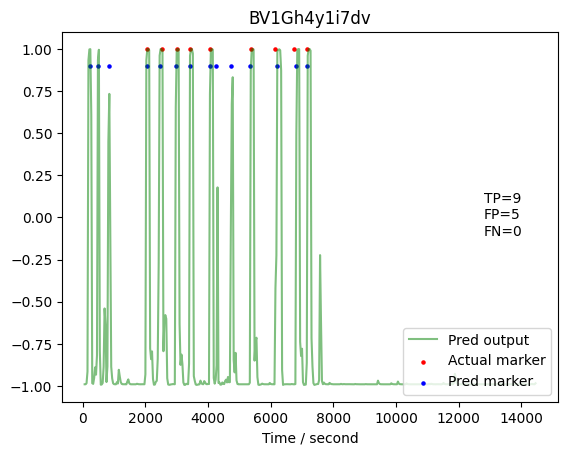

BV BV1Gh4y1i7dv TP 9 FP 5 FN 0
12/12 [==============================] - 0s 2ms/step
BV BV1ye411X7AP Length 11400


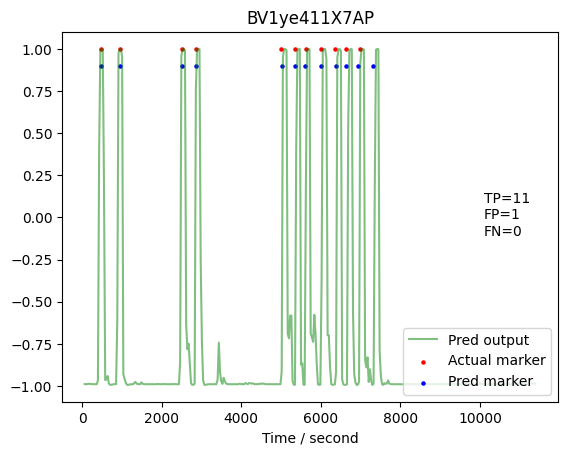

BV BV1ye411X7AP TP 11 FP 1 FN 0
12/12 [==============================] - 0s 2ms/step
BV BV1n24y1t7Xb Length 11250


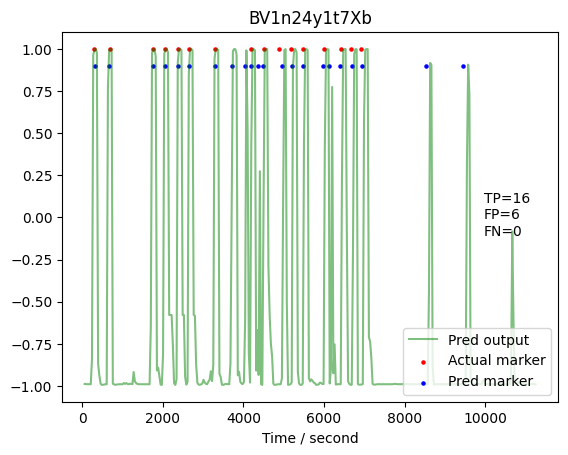

BV BV1n24y1t7Xb TP 16 FP 6 FN 0
10/10 [==============================] - 0s 2ms/step
BV BV1os4y1J7TK Length 9690


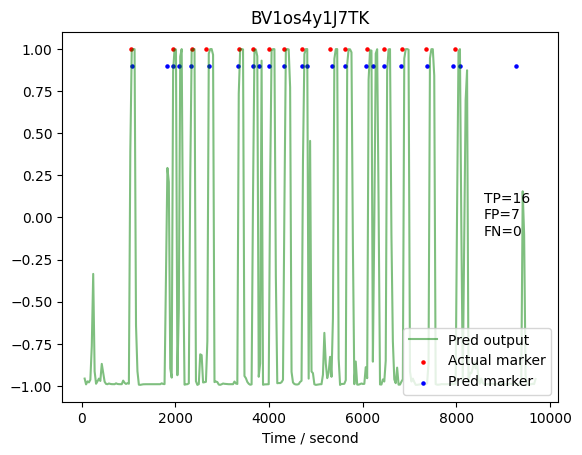

BV BV1os4y1J7TK TP 16 FP 7 FN 0
15/15 [==============================] - 0s 2ms/step
BV BV1Hw411z7Sv Length 13890


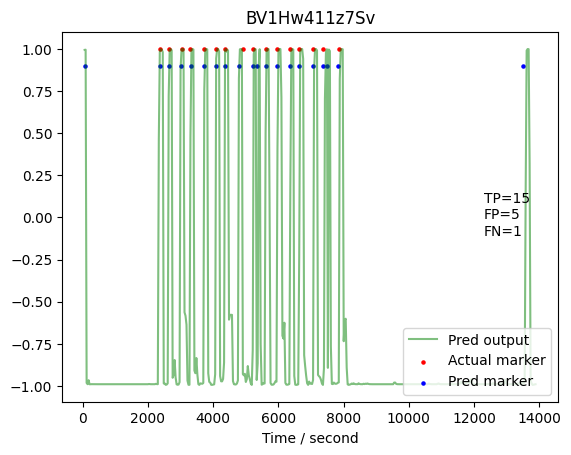

BV BV1Hw411z7Sv TP 15 FP 5 FN 1
10/10 [==============================] - 0s 3ms/step
BV BV1JN4y1U7ba Length 9750


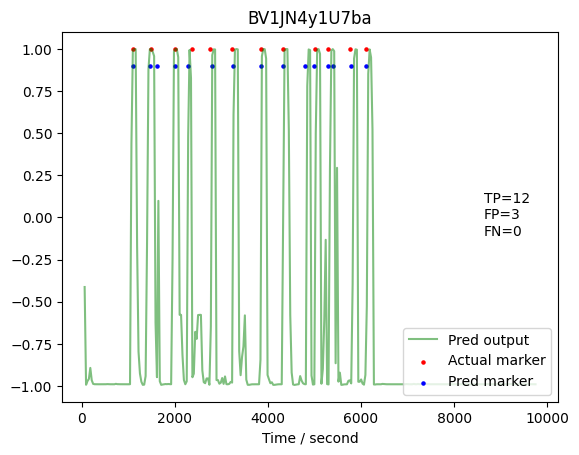

BV BV1JN4y1U7ba TP 12 FP 3 FN 0
11/11 [==============================] - 0s 3ms/step
BV BV1gu4y1Q7V2 Length 9900


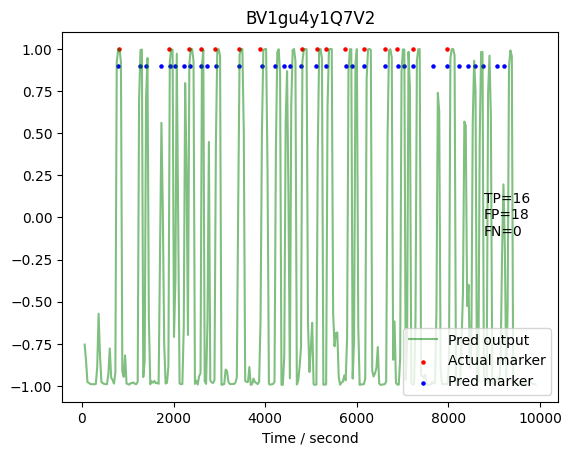

BV BV1gu4y1Q7V2 TP 16 FP 18 FN 0
10/10 [==============================] - 0s 3ms/step
BV BV1CL411q77Y Length 9750


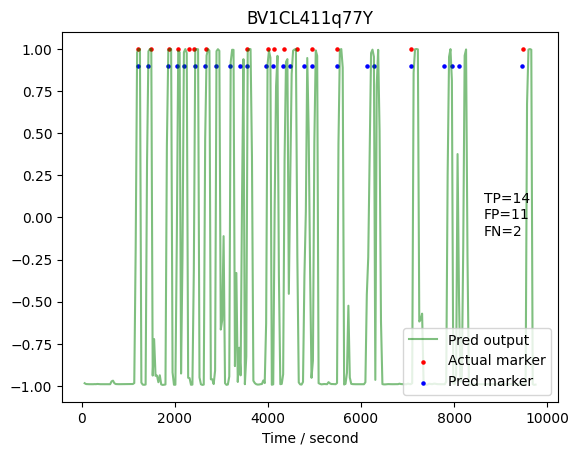

BV BV1CL411q77Y TP 14 FP 11 FN 2


In [ ]:
outcome_dict = {}
for BV in test_BV_list:
  TP, FP, FN = get_score_show(*evaluate(BV), BV)
  print("BV", BV, "TP", TP, "FP", FP, "FN", FN)
  outcome_dict.update({BV: (TP, FP, FN)})

In [ ]:
# save raw outcome
arr = []
for BV in outcome_dict:
  TP, FP, FN = outcome_dict[BV]
  arr.append([BV, TP, FP, FN])
np.array(arr)
np.save(os.path.join(DIR_NAME, "slicer_outcome.npy") , arr)
print(arr)

[['BV1Gh4y1i7dv', 9, 5, 0], ['BV1ye411X7AP', 11, 1, 0], ['BV1n24y1t7Xb', 16, 6, 0], ['BV1os4y1J7TK', 16, 7, 0], ['BV1Hw411z7Sv', 15, 5, 1], ['BV1JN4y1U7ba', 12, 3, 0], ['BV1gu4y1Q7V2', 16, 18, 0], ['BV1CL411q77Y', 14, 11, 2]]


In [ ]:
# Deprecated, use MLP instead.
#########################
# Apply majority voting #
#########################

# MV_PTS = 26
# SAMPLE_RATE = 22050

# mv_list = []
# for i in range(0, len(pred_list) - MV_PTS + 1, MV_PTS):
#   if (pred_list[i : i+MV_PTS, 1] - pred_list[i : i+MV_PTS, 0] > 0).sum() > MV_PTS / 2:
#     mv_list.append(1)
#   else:
#     mv_list.append(0)
# mv_list = np.array(mv_list)


# plt.xlim([4000, 6000])

# plt.plot(np.linspace(0, 10111, len(mv_list)), mv_list, alpha=0.75, label="pred")
# plt.scatter(marker + MV_PTS/2 * STEP_SIZE / SAMPLE_RATE, np.ones(len(marker)), c='r', s=5, label="Actual label")

# plt.show()

### Evaluation

In [ ]:
# marker


In [ ]:
# # def eval_pred(marker, pred, step_sec):
# true_positive = 0
# step_sec = 75
# for m in marker:
#   if mlp_pred_1D[int((m+30)/step_sec)] > 0 or mlp_pred_1D[int((m+30)/step_sec)+1] > 0:
#     true_positive += 1
# print(true_positive, "/", len(marker))
# # Actually from above figure the outcome should be much better than 11/19.
# # Refine the evaluation method.